<b>Legacy Code</b>: Initial explorations into computing spatio-temporal receptive fields for the Ret-1 CRCNS dataset.

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from UoI_Lasso import UoI_Lasso

from ret1_utils import Retina

%matplotlib inline

In [3]:
datapath = 'data/20080516_R1.mat'

In [4]:
f = loadmat(datapath, struct_as_record=False)

In [5]:
sessions = f['stimulus'].ravel()
spikes = f['spikes']
n_cells = np.asscalar(np.asscalar(f['datainfo']).Ncell)

In [63]:
# choose recording number
recording = 0
window_length = 0.35 # in seconds

# extract session
session = sessions[recording]

# number of frames
n_frames = np.asscalar(session.Nframes)
frame_length = np.asscalar(session.frame)
onset = np.asscalar(session.onset)

n_frames_per_window = int(np.round(window_length/frame_length))

# timepoints
t = np.arange(n_frames) * frame_length + onset
N = t.size - 1

# n features
params = np.asscalar(session.param)
Nx = np.asscalar(params.x)/np.asscalar(params.dx)
Ny = np.asscalar(params.y)/np.asscalar(params.dy)
m = int(Nx * Ny)

In [68]:
responses = np.zeros((N, n_cells))
for cell in range(n_cells):
    spike_times = spikes[cell, recording]
    # bin spike train
    binned_spikes, _ = np.histogram(spike_times, bins=t)
    
    # put spikes in array
    binned_spikes[:n_frames_per_window-1] = 0
    n_spikes = np.sum(binned_spikes)
    
    responses[:, cell] = binned_spikes/n_spikes

In [70]:
byte = np.fromfile('data/ran1.bin', count=N*m//8, dtype='uint8')
stims = np.unpackbits(byte).astype('float32')
stims = 2 * stims - 1
stims = stims.reshape((N, m)).T

# STA

In [17]:
sta = np.zeros((n_frames_per_window, m))
responses_copy = np.copy(responses)

for window in range(n_frames_per_window):
    sta[window, :] = np.dot(stims, responses_copy[:, 1])
    #print(r2_score(responses_copy[:, 0], np.dot(stims.T, sta[window, :])))
    responses_copy = np.roll(responses_copy, -1, axis=0)

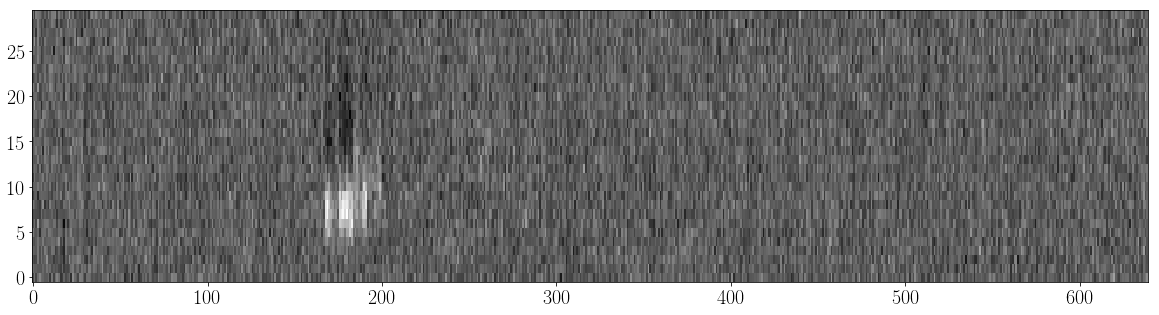

In [18]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.imshow(sta, cmap='gray')
ax.set_aspect('auto')

# Linear Regression

In [72]:
ruff = retina.calculate_strf_for_neurons(method='OLS', recording=recording, window_length=window_length, cells=0)

In [27]:
ols_strf = np.zeros((n_frames_per_window, m))
responses_copy = np.copy(responses)

for window in range(n_frames_per_window):
    ols = LinearRegression(fit_intercept=True)
    ols.fit(stims.T, responses_copy[:, 2])
    ols_strf[window, :] = ols.coef_.T
    #print(r2_score(responses_copy[:, 0], ols.predict(stims.T)))
    responses_copy = np.roll(responses_copy, -1, axis=0)

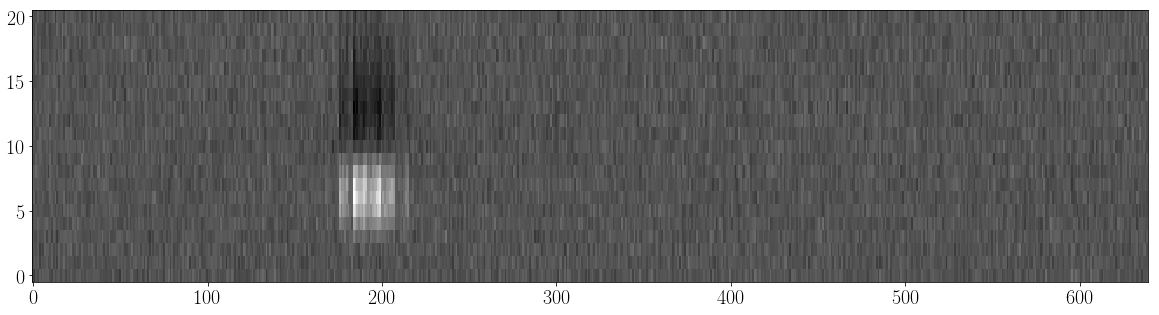

In [73]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.imshow(ruff[0], cmap='gray')
ax.set_aspect('auto')

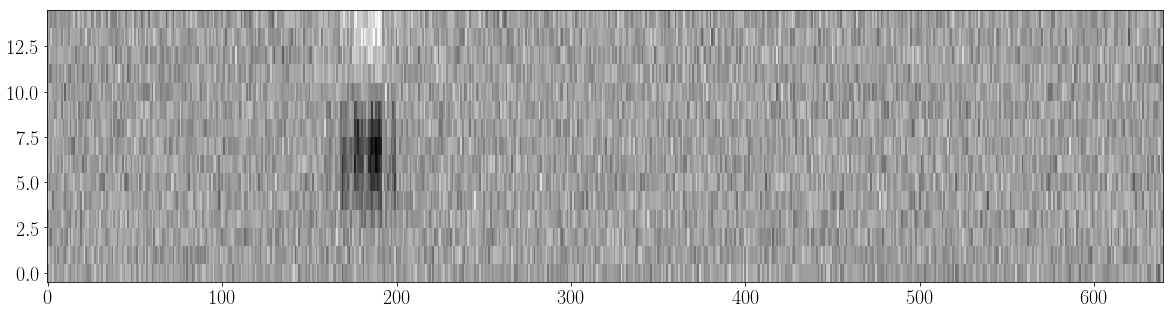

In [29]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.imshow(ols_strf, cmap='gray')
ax.set_aspect('auto')

# Ridge Regression

In [31]:
ridge_strf = np.zeros((n_frames_per_window, m))
responses_copy = np.copy(responses)

for window in range(n_frames_per_window):
    print(window)
    ridge = RidgeCV(
        cv=5
    )
    ridge.fit(stims.T, responses_copy[:, 0])
    ridge_strf[window, :] = ridge.coef_.T
    #print(r2_score(responses_copy[:, 0], ridge.predict(stims.T)))
    responses_copy = np.roll(responses_copy, -1, axis=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


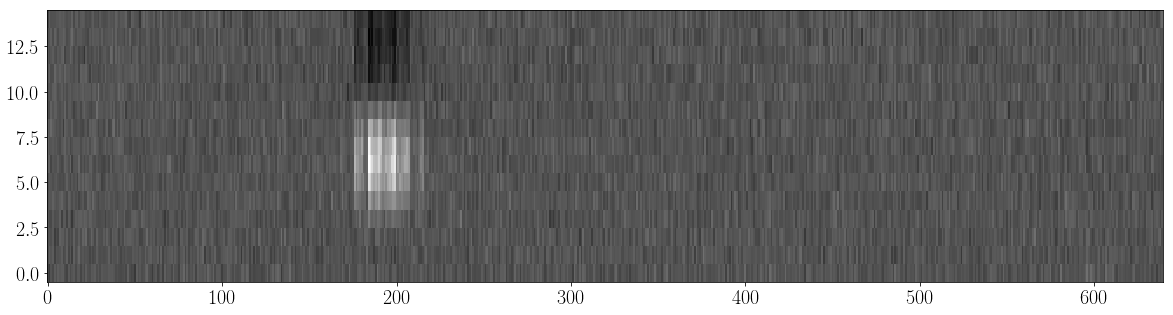

In [32]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.imshow(ridge_strf, cmap='gray')
ax.set_aspect('auto')

# Lasso CV

In [48]:
lasso_strf = np.zeros((n_frames_per_window, m))
responses_copy = np.copy(responses)

for window in range(n_frames_per_window):
    print(window)
    lasso = LassoCV(
        normalize=True,
        cv=5
    )
    lasso.fit(stims.T, responses_copy[:, 0])
    lasso_strf[window, :] = lasso.coef_.T
    responses_copy = np.roll(responses_copy, -1, axis=0)
    #print(r2_score(responses_copy[:, 0], lasso.predict(stims.T)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


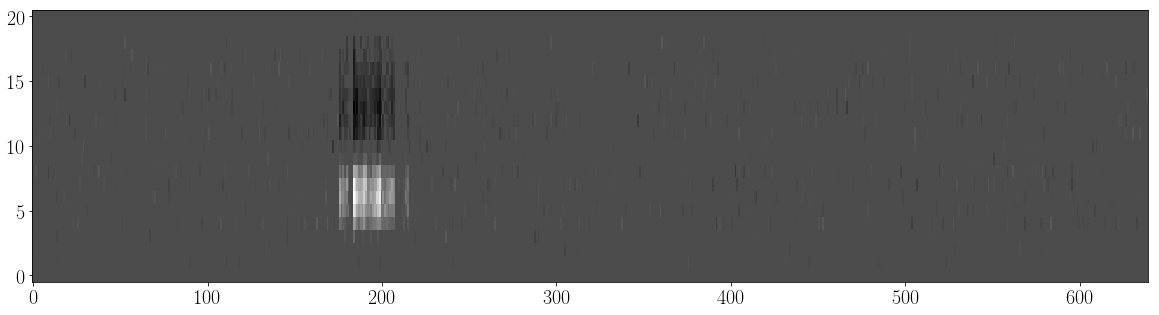

In [75]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.imshow(gimme[0], cmap='gray')
ax.set_aspect('auto')

# UoI Lasso

In [9]:
# uoi lasso

uoi_strfs = np.zeros((n_frames_per_window, m))
responses_copy = np.copy(responses)[:, 0]
responses_copy = np.roll(responses_copy, -5, axis=0)

for window in range(1):
    print(window)
    uoi = UoI_Lasso(
        n_lambdas=30,
        normalize=True,
        fit_intercept=True,
        estimation_score='BIC',
        n_boots_sel=30,
        n_boots_est=30,
        selection_thres_min=1.0
    )
    uoi.fit(stims.T, responses_copy, verbose=True)
    uoi_strfs[window, :] = uoi.coef_.T
    responses_copy = np.roll(responses_copy, -5, axis=0)
    
print(uoi_strfs[0, :])

0
(1) Loaded data.
 89898 samples with 640 features.


Model Estimation:   0%|          | 0/30 [00:00<?, ?it/s]

(3) Beginning model estimation, with 30 bootstraps.


Model Estimation: 100%|██████████| 30/30 [09:34<00:00, 19.16s/it]

(4) Bagging estimates, using bagging option 1.
---> UoI Lasso complete.
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+

# Comparison

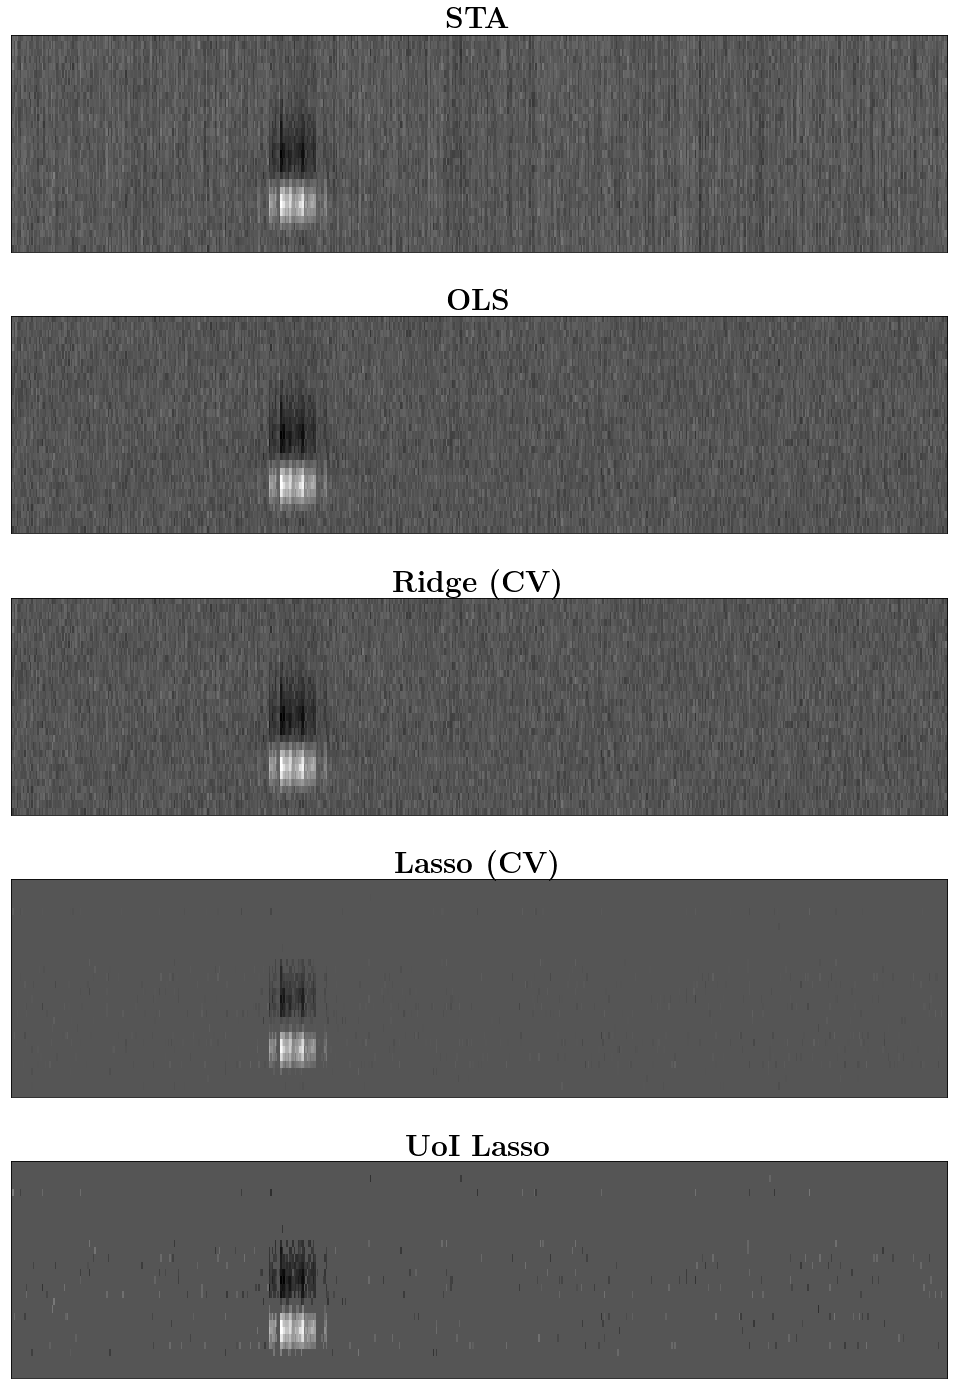

In [53]:
fig, axes = plt.subplots(5, 1, figsize=(14, 20))


axes[0].imshow(sta[:, :, 0], cmap='gray')
axes[0].set_title(r'\textbf{STA}')

axes[1].imshow(ols_strf, cmap='gray', vmin=-5e-7, vmax=1e-6)
axes[1].set_title(r'\textbf{OLS}')

axes[2].imshow(ridge_strf, cmap='gray', vmin=-5e-7, vmax=1e-6)
axes[2].set_title(r'\textbf{Ridge (CV)}')

axes[3].imshow(lasso_strf, cmap='gray', vmin=-5e-7, vmax=1e-6)
axes[3].set_title(r'\textbf{Lasso (CV)}')

axes[4].imshow(uoi_strfs, cmap='gray', vmin=-5e-7, vmax=1e-6)
axes[4].set_title(r'\textbf{UoI Lasso}')
                  
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')
    

plt.tight_layout()
plt.savefig('retina_strf.pdf')